<a href="https://colab.research.google.com/github/logfabio/knowledge-engineering-project/blob/main/CNN_Gravina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Monuments Classification
Fabio Loguercio



## Fine tuning
Utilizzo il fine tuning della rete VGG16. 
Per prima cosa, effettuo gli import necessari per l'esecuzione del progetto.

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import random
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint
import math

Definisco alcune costanti: `IMAGE_SIZE` specifica la dimensione dell'immagine (altezza e larghezza) in pixel. VGG16 è stata addestrata su immagini a colori con dimensione 224x224 pixel.



In [ ]:
IMAGE_SIZE = 224
random.seed(3)

Carico il modello VGG16, andando a definire con `weights` i pesi ottenuti con l'addestramento della rete su ImageNet, con `include_top` impostato a `False` decido di non includere l'ultimo blocco di layer fully connected (Fully-Connected Classifier) e, infine, con `input_shape` definisco la dimensione delle immagini in input alla rete.

In [ ]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

58900480/58889256 [==============================] - 0s 0us/step


Per effettuare il fine tuning della rete vado a congelare i pesi di tutti i layer, eccetto gli ultimi 4 (Conv Block #5).

In [ ]:
for layer in vgg16.layers[:-4]:
  layer.trainable = False

Sostituisco i layer non inclusi in precedenza con dei nuovi layer che si occuperanno di effettuare la classificazione. 

Quindi creo un nuovo modello di tipo Sequential al quale aggiungo tutti i layer considerati in precedenza di VGG16 e i seguenti nuovi layer:
*   Flatten
*   Dense
*   Dropout
*   Dense

In [ ]:
model = Sequential()

model.add(vgg16)

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(17, activation="softmax"))

vgg16.summary()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Accedo al Google Drive per caricare il dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Definita la struttura della rete, vado a definire le cartelle per il training set e per il validation set.

In [ ]:
train_folder = "/content/drive/MyDrive/Colab Notebooks/Dataset Gravina/Train/"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.15)


Con il metodo flow_from_directory() vado a creare i batch con le immagini preprocessate. 

La dimensione dei batch di training è di 34, mentre quella dei batch di validation è di 8.

In [ ]:
train_batchsize = 34
val_batchsize = 8

train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical",
        subset='training'
)

val_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False,
        subset='validation'
)

Found 318 images belonging to 17 classes.
Found 48 images belonging to 17 classes.


Per il salvataggio del modello prenderò il modello che durante tutte le epoche di training, ha fatto registrare l'accuracy sul validation set maggiore.

Creo una lista chiamata `callbacks_list`, per definire altre azioni da eseguire al termine di ogni epoca  

In [ ]:
filepath = "model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Definisco altri iperparametri per effettuare il training

In [ ]:
num_epochs = 30
learning_rate = 1.25e-4
adam = Adam(lr=learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Faccio partire il training

In [ ]:
history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        verbose=1,
        callbacks=callbacks_list
    )

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 9.9120 - acc: 0.1761  
Epoch 1: val_acc improved from -inf to 0.37500, saving model to model.hdf5
10/10 [==============================] - 233s 23s/step - loss: 9.9120 - acc: 0.1761 - val_loss: 1.9347 - val_acc: 0.3750
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 1.5832 - acc: 0.5189
Epoch 2: val_acc improved from 0.37500 to 0.66667, saving model to model.hdf5
10/10 [==============================] - 44s 5s/step - loss: 1.5832 - acc: 0.5189 - val_loss: 1.3651 - val_acc: 0.6667
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.5399 - acc: 0.8333
Epoch 3: val_acc improved from 0.66667 to 0.77083, saving model to model.hdf5
10/10 [==============================] - 44s 4s/step - loss: 0.5399 - acc: 0.8333 - val_loss: 1.0185 - val_acc: 0.7708
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.0822 - acc: 0.9717
Epoch 4: val_acc improved from 0.77083 to 0.79167, s

Visualizzo su grafico l'andamento dell'accuracy e della funzione di loss durante le epoche

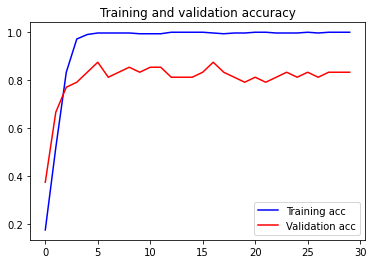

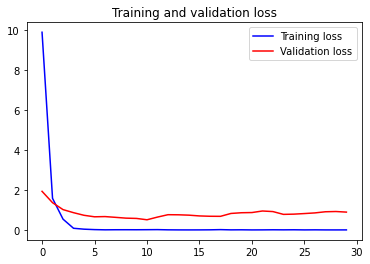

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
    

## Test
Dopo aver creato il modello della rete, posso testarlo con le immagini presenti nel test set.

Effettuiamo gli import necessari allo scopo.

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn import metrics
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import seaborn as sns
from keras.applications.vgg16 import preprocess_input

Definisco la funzione `show_confusion_matrix()` che servirà più tardi per creare il grafico con la matrice di confusione.

In [ ]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Imposto alcuni parametri, come il path del test set, la dimensione delle immagini in input alla rete e la dimensione del batch per il test

In [ ]:
test_folder = "/content/drive/MyDrive/Colab Notebooks/Dataset Gravina/Test/"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

Successivamente, carico il modello creato in precedenza

In [ ]:
model = load_model("model.hdf5")

E, proprio come per il training, vado a caricare le immagini con i seguenti metodi

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 90 images belonging to 17 classes.


Vado a leggere le classi assegnate agli esempi di test e il corrispettivo indice numerico

In [ ]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

Effettuo la classificazione degli esempi di test

In [ ]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


90/90 [==============================] - 76s 841ms/step


Calcolo il numero di errori effettuati dal modello, la matrice di confusione e visualizzo le metriche prestazionali

No of errors = 9/90


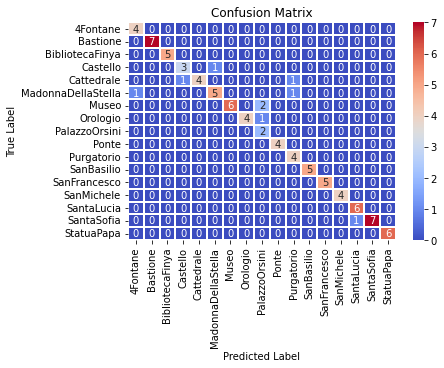

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       0.75      0.75      0.75         4
           4       1.00      0.67      0.80         6
           5       0.83      0.71      0.77         7
           6       1.00      0.75      0.86         8
           7       1.00      0.80      0.89         5
           8       0.40      1.00      0.57         2
           9       1.00      1.00      1.00         4
          10       0.67      1.00      0.80         4
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         4
          14       0.86      1.00      0.92         6
          15       1.00      0.88      0.93         8
          16       1.00      1.00      1.00         6

    accuracy              

In [ ]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["4Fontane", "Bastione","BibliotecaFinya","Castello","Cattedrale","MadonnaDellaStella","Museo","Orologio","PalazzoOrsini","Ponte","Purgatorio","SanBasilio","SanFrancesco","SanMichele","SantaLucia","SantaSofia","StatuaPapa"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))